In [78]:
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils

import torchvision
import torch.nn as nn 
from torchvision.datasets import VOCDetection
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import torch 
from typing import Dict, Any, List
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import collections

In [79]:
images_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/voc/VOCdevkit/VOC2007/JPEGImages"
anno_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/voc/VOCdevkit/VOC2007/Annotations"

# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

image_size_ = 600
dataset_ = RS_dataset.Detection_Dataset_v2(images_path, anno_path, classes, image_size=image_size_,normalizing=True)
loader_ = DataLoader(dataset_, batch_size=8, collate_fn=dataset_.collate_fn)

#--------------------------------
# grab a batch for demonstration

for img_batch, gt_bboxes_batch, gt_classes_batch in loader_:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break


#-----------------------------------
# model to calculate the dimension 

model = torchvision.models.resnet50(pretrained=True)

req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True
    
# run the image through the backbone
out = backbone(img_data_all)

out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

# check the scale 

width_scale_factor = image_size_ // out_w
height_scale_factor = image_size_ // out_h


img_height = 600 
img_width  = 600
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = 20 # exclude pad idx
roi_size = (2, 2)
DEVICE = "cuda:0"


In [80]:
a, b, c = dataset_.__getitem__(4)
#img_ = RS_utils.torch_denormalize(img_)

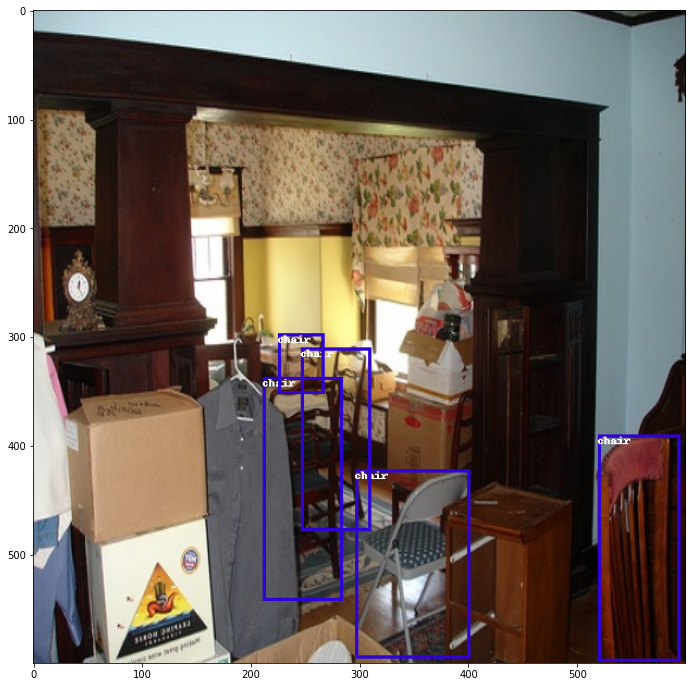

In [81]:
RS_utils.show_box(a, b,c, classes, denormal=True)

In [82]:
b

tensor([[211.2000, 337.6000, 284.4000, 542.4000],
        [296.4000, 422.4000, 402.0000, 595.2000],
        [519.6000, 390.4000, 594.0000, 598.4000],
        [246.0000, 310.4000, 310.8000, 478.4000],
        [225.6000, 297.6000, 267.6000, 352.0000]], dtype=torch.float64)

In [83]:
c

tensor([8., 8., 8., 8., 8.], dtype=torch.float64)

In [84]:
#---
a = a.unsqueeze(0)
print(a.shape)
#---
detector = RS_models.TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size, device=DEVICE)

# inference 
saved_model_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Tasks/ObjectDetection/02.ckpts/ver_8_Object_Detection_FasterRCNN_epoch_20_iteration_26166.pt"
detector.load_state_dict(torch.load(saved_model_path))
detector.eval()

proposals_final, conf_scores_final, classes_final = detector.inference(a, conf_thresh=0.9, nms_thresh=0.05)

print(proposals_final)
# project proposals to the image space
prop_proj_1 = RS_utils.project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
#prop_proj_2 = RS_utils.project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')


# get classes
idx2name = {}
for i, name in enumerate(classes):
    idx2name[i] = name
idx2name[-1] = 'pad' 

classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
#classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]


# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# fig, axes = display_img(img_batch, fig, axes)
# fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)


torch.Size([1, 3, 600, 600])
[tensor([[ 3.6787,  3.9884, 16.4120, 16.4009]])]


In [85]:
prop_proj_1[0:2]

tensor([[114.0390, 123.6400, 508.7733, 508.4271]])

In [86]:
conf_scores_final[0][0:2]

tensor([0.9726])

batch


<Figure size 720x720 with 0 Axes>

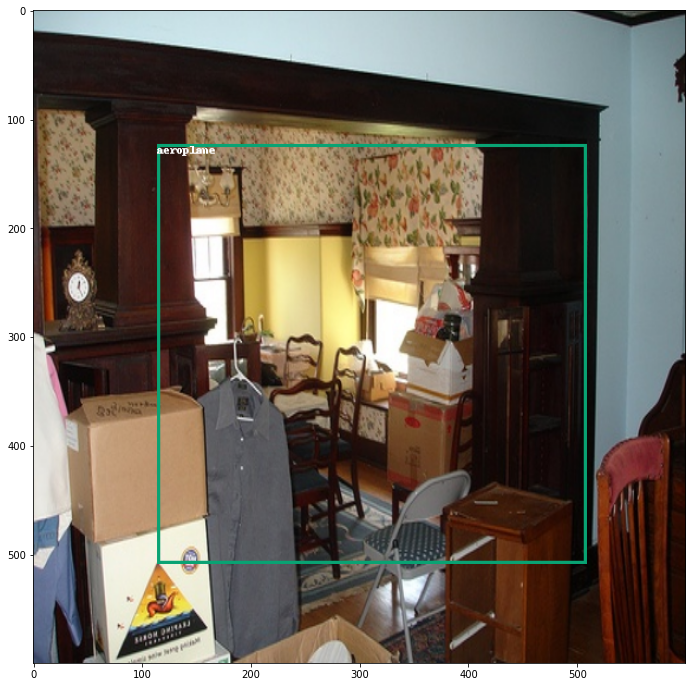

In [87]:
plt.figure(figsize=(10,10))

numbers = 5
bboxes = prop_proj_1[0:numbers]
scores = conf_scores_final[0][0:numbers]

RS_utils.show_box(a, bboxes, scores, classes = classes , denormal=False)

In [88]:
plt.figure(figsize=(10,10))
RS_utils.show_box(img_, prop_proj_1, label_, classes=classes)

NameError: name 'img_' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
# # # -------------- Visualization utils ----------------

# def display_img(img_data, fig, axes):
#     for i, img in enumerate(img_data):
#         if type(img) == torch.Tensor:
#             img = img.permute(1, 2, 0).numpy()
#         axes[i].imshow(img)
    
#     return fig, axes

# def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
#     if type(bboxes) == np.ndarray:
#         bboxes = torch.from_numpy(bboxes)
#     if classes:
#         assert len(bboxes) == len(classes)
#     # convert boxes to xywh format
#     bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
#     c = 0
#     for box in bboxes:
#         x, y, w, h = box.numpy()
#         # display bounding box
#         rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
#         ax.add_patch(rect)
#         # display category
#         if classes:
#             if classes[c] == 'pad':
#                 continue
#             ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
#         c += 1
        
#     return fig, ax

# def display_grid(x_points, y_points, fig, ax, special_point=None):
#     # plot grid
#     for x in x_points:
#         for y in y_points:
#             ax.scatter(x, y, color="w", marker='+')
            
#     # plot a special point we want to emphasize on the grid
#     if special_point:
#         x, y = special_point
#         ax.scatter(x, y, color="red", marker='+')
        
#     return fig, ax